# 初期EDA - データ概要把握

**目的**: データの基本情報、欠損値、データ型、統計量を把握する

**このノートブックで行うこと**:
1. データの読み込み
2. 基本情報の確認（shape, dtypes, memory）
3. 欠損値の分析
4. データ型の確認
5. 数値カラムの統計量
6. カテゴリカラムの分布
7. 重複行の確認

## セットアップ

In [ ]:
import sys
import os
from pathlib import Path
import warnings

# ワーニングを非表示
warnings.filterwarnings('ignore')

# プロジェクトルートをパスに追加
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))

# 作業ディレクトリをプロジェクトルートに変更
os.chdir(project_root)

import polars as pl

# matplotlibのバックエンドを先に設定（高速化）
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns

# スタイルを先に設定（フォント設定の前に）
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# 日本語フォント設定
try:
    import japanize_matplotlib
    japanize_matplotlib.japanize()
except ImportError:
    # japanize-matplotlibがない場合はデフォルトフォント
    plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']

# マイナス記号の文字化け対策
plt.rcParams['axes.unicode_minus'] = False

# 自作モジュール
from src.data.loader import DataLoader
from src.utils.config import load_config
from src.eda.profiler import (
    get_basic_info,
    get_missing_info,
    get_dtype_summary,
    get_numerical_summary,
    get_categorical_summary,
    get_duplicate_info,
    print_profile_summary,
)
from src.eda.visualizer import (
    plot_missing_heatmap,
    plot_distribution,
    plot_categorical_distribution,
    plot_correlation_heatmap,
)

%matplotlib inline

# Polars設定
pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(15)

print("✓ セットアップ完了")
print(f"  プロジェクトルート: {project_root.name}/")
print(f"  使用フォント: {plt.rcParams['font.sans-serif'][0]}")

## 1. データ読み込み

In [2]:
# 設定ファイル読み込み
data_config = load_config("data")

# DataLoader初期化
loader = DataLoader(data_config)

# データ読み込み
train = loader.load_train()
test = loader.load_test()

print(f"訓練データ: {train.shape}")
print(f"テストデータ: {test.shape}")

訓練データ: (363924, 149)
テストデータ: (112437, 149)


In [3]:
train.head()

target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,…,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
i64,i64,i64,i64,str,str,i64,…,str,i64,str,i64,str,str,str
201901,13980000,206271,1,"""2014-06-27 21:09:41""","""2019-01-24 00:10:08""",4,…,null,null,"""210101/220701/220601/230401/31…",null,null,null,null
201901,24480000,83315,1,"""2014-06-27 21:09:43""","""2019-04-03 00:10:08""",4,…,null,null,"""210101/220701/220601/220801/23…",null,null,null,null
201901,24480000,140201,1,"""2014-06-27 21:09:43""","""2020-06-06 00:10:11""",4,…,null,null,"""210101/220701/220601/230401/22…",null,null,null,null
201901,16300000,216551,1,"""2014-06-27 19:24:11""","""2019-04-26 00:10:08""",4,…,"""コンビニ""",300,"""210101/290901/230401/210301/21…",null,null,null,null
201901,18800000,134968,1,"""2014-06-27 19:24:12""","""2025-09-15 02:49:23""",1,…,"""駅""",300,"""220801/220401/250101/220701/32…",null,null,null,null


## 2. プロファイルサマリー

データの全体像を一覧で確認

In [4]:
print_profile_summary(train, name="訓練データ")

訓練データ - データプロファイル

[基本情報]
  行数: 363,924
  列数: 149
  メモリ使用量: 473.97 MB

[データ型]
shape: (3, 3)
┌─────────┬───────┬─────────────────────────────────┐
│ dtype   ┆ count ┆ columns                         │
│ ---     ┆ ---   ┆ ---                             │
│ str     ┆ i64   ┆ str                             │
╞═════════╪═══════╪═════════════════════════════════╡
│ Int64   ┆ 80    ┆ target_ym, money_room, buildin… │
│ String  ┆ 51    ┆ building_create_date, building… │
│ Float64 ┆ 18    ┆ lon, lat, total_floor_area, bu… │
└─────────┴───────┴─────────────────────────────────┘

[欠損値 - 上位10件]
shape: (10, 3)
┌──────────────────────┬────────────┬────────────┐
│ column               ┆ null_count ┆ null_ratio │
│ ---                  ┆ ---        ┆ ---        │
│ str                  ┆ i64        ┆ f64        │
╞══════════════════════╪════════════╪════════════╡
│ building_name_ruby   ┆ 363924     ┆ 1.0        │
│ name_ruby            ┆ 363924     ┆ 1.0        │
│ school_ele_code      ┆ 363924    

  総行数: 363,924
  ユニーク行数: 363,924
  重複行数: 0
  重複割合: 0.00%



In [5]:
print_profile_summary(test, name="テストデータ")

テストデータ - データプロファイル

[基本情報]
  行数: 112,437
  列数: 149
  メモリ使用量: 148.7 MB

[データ型]
shape: (3, 3)
┌─────────┬───────┬─────────────────────────────────┐
│ dtype   ┆ count ┆ columns                         │
│ ---     ┆ ---   ┆ ---                             │
│ str     ┆ i64   ┆ str                             │
╞═════════╪═══════╪═════════════════════════════════╡
│ Int64   ┆ 83    ┆ id, target_ym, building_id, bu… │
│ String  ┆ 52    ┆ building_create_date, building… │
│ Float64 ┆ 14    ┆ lon, lat, total_floor_area, bu… │
└─────────┴───────┴─────────────────────────────────┘

[欠損値 - 上位10件]
shape: (10, 3)
┌──────────────────────┬────────────┬────────────┐
│ column               ┆ null_count ┆ null_ratio │
│ ---                  ┆ ---        ┆ ---        │
│ str                  ┆ i64        ┆ f64        │
╞══════════════════════╪════════════╪════════════╡
│ building_name_ruby   ┆ 112437     ┆ 1.0        │
│ name_ruby            ┆ 112437     ┆ 1.0        │
│ traffic_car          ┆ 112437    

## 3. 基本情報の詳細確認

In [6]:
# 訓練データの基本情報
train_info = get_basic_info(train)

print("[訓練データ 基本情報]")
print(f"Shape: {train_info['shape']}")
print(f"Columns: {len(train_info['columns'])}")
print(f"Memory: {train_info['memory_mb']} MB")
print(f"\nカラム一覧（最初の20件）:")
print(train_info['columns'][:20])

[訓練データ 基本情報]
Shape: (363924, 149)
Columns: 149
Memory: 473.97 MB

カラム一覧（最初の20件）:
['target_ym', 'money_room', 'building_id', 'building_status', 'building_create_date', 'building_modify_date', 'building_type', 'building_name', 'building_name_ruby', 'homes_building_name', 'homes_building_name_ruby', 'unit_count', 'full_address', 'lon', 'lat', 'building_structure', 'total_floor_area', 'building_area', 'floor_count', 'basement_floor_count']


In [7]:
# データ型サマリー
dtype_summary = get_dtype_summary(train)
print("[データ型サマリー]")
print(dtype_summary)

[データ型サマリー]
shape: (3, 3)
┌─────────┬───────┬─────────────────────────────────┐
│ dtype   ┆ count ┆ columns                         │
│ ---     ┆ ---   ┆ ---                             │
│ str     ┆ i64   ┆ str                             │
╞═════════╪═══════╪═════════════════════════════════╡
│ Int64   ┆ 80    ┆ target_ym, money_room, buildin… │
│ String  ┆ 51    ┆ building_create_date, building… │
│ Float64 ┆ 18    ┆ lon, lat, total_floor_area, bu… │
└─────────┴───────┴─────────────────────────────────┘


## 4. 欠損値分析

In [8]:
# 欠損値情報
missing_info = get_missing_info(train)

print("[欠損値 - 上位20件]")
print(missing_info.head(20))

[欠損値 - 上位20件]
shape: (20, 3)
┌─────────────────────────┬────────────┬────────────┐
│ column                  ┆ null_count ┆ null_ratio │
│ ---                     ┆ ---        ┆ ---        │
│ str                     ┆ i64        ┆ f64        │
╞═════════════════════════╪════════════╪════════════╡
│ building_name_ruby      ┆ 363924     ┆ 1.0        │
│ name_ruby               ┆ 363924     ┆ 1.0        │
│ school_ele_code         ┆ 363924     ┆ 1.0        │
│ school_jun_code         ┆ 363924     ┆ 1.0        │
│ money_hoshou_company    ┆ 363924     ┆ 1.0        │
│ free_rent_duration      ┆ 363924     ┆ 1.0        │
│ free_rent_gen_timing    ┆ 363924     ┆ 1.0        │
│ traffic_car             ┆ 363920     ┆ 0.999989   │
│ reform_etc              ┆ 363495     ┆ 0.998821   │
│ reform_place_other      ┆ 363055     ┆ 0.997612   │
│ reform_place            ┆ 362888     ┆ 0.997153   │
│ reform_date             ┆ 362656     ┆ 0.996516   │
│ reform_common_area      ┆ 361621     ┆ 0.993672   │

In [9]:
# 欠損値が50%以上のカラム
high_missing = missing_info.filter(pl.col("null_ratio") >= 0.5)

print(f"[欠損値50%以上のカラム: {high_missing.height}件]")
if high_missing.height > 0:
    print(high_missing)

[欠損値50%以上のカラム: 76件]
shape: (76, 3)
┌───────────────────────┬────────────┬────────────┐
│ column                ┆ null_count ┆ null_ratio │
│ ---                   ┆ ---        ┆ ---        │
│ str                   ┆ i64        ┆ f64        │
╞═══════════════════════╪════════════╪════════════╡
│ building_name_ruby    ┆ 363924     ┆ 1.0        │
│ name_ruby             ┆ 363924     ┆ 1.0        │
│ school_ele_code       ┆ 363924     ┆ 1.0        │
│ school_jun_code       ┆ 363924     ┆ 1.0        │
│ money_hoshou_company  ┆ 363924     ┆ 1.0        │
│ free_rent_duration    ┆ 363924     ┆ 1.0        │
│ free_rent_gen_timing  ┆ 363924     ┆ 1.0        │
│ traffic_car           ┆ 363920     ┆ 0.999989   │
│ reform_etc            ┆ 363495     ┆ 0.998821   │
│ reform_place_other    ┆ 363055     ┆ 0.997612   │
│ …                     ┆ …          ┆ …          │
│ unit_area_min         ┆ 237462     ┆ 0.652504   │
│ unit_area_max         ┆ 237462     ┆ 0.652504   │
│ land_setback_flg      ┆ 228

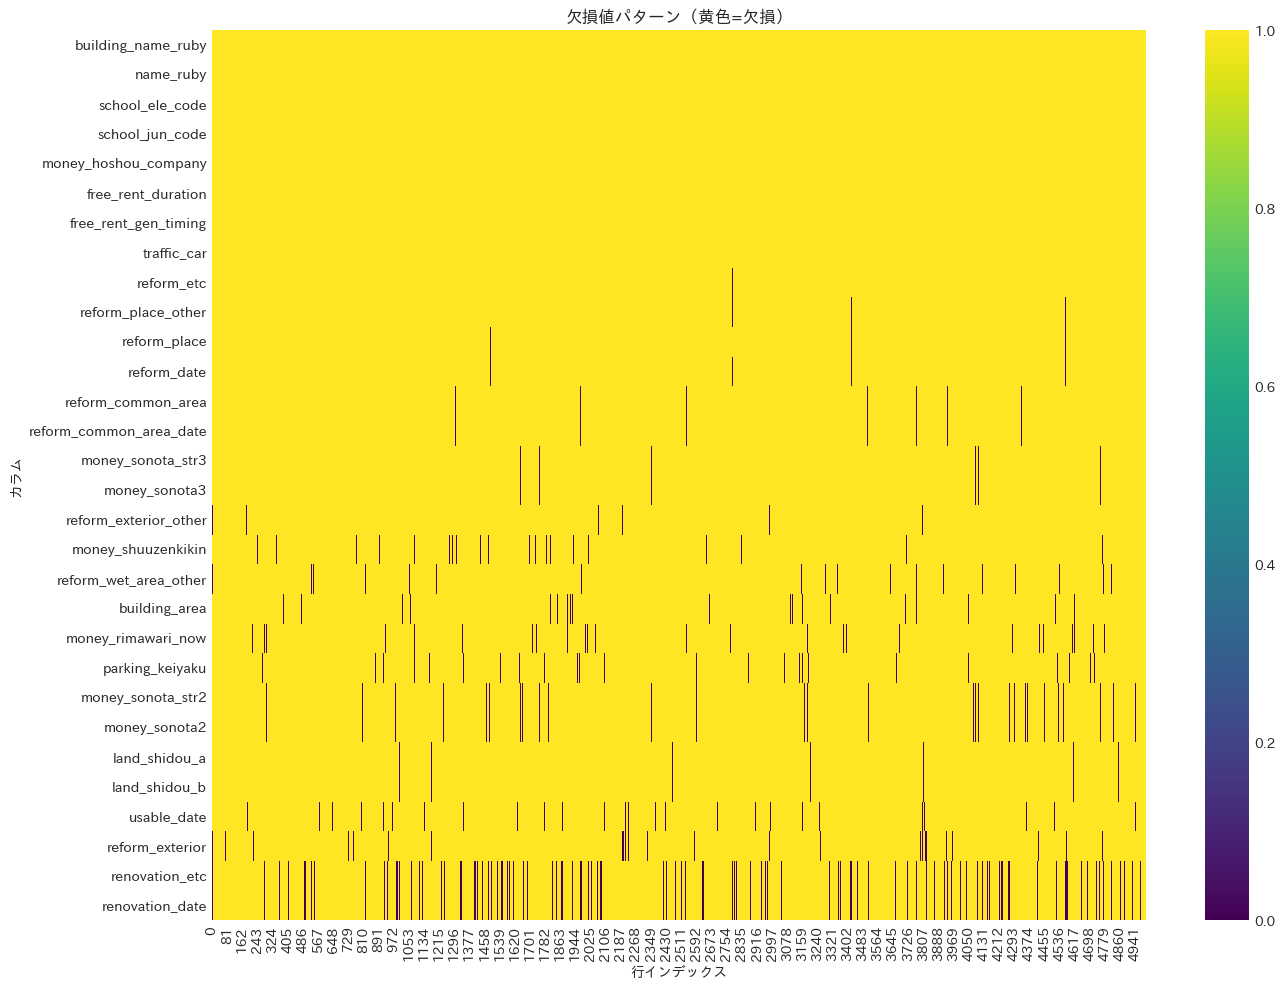

In [10]:
# 欠損値ヒートマップ（サンプリング表示）
# 全データだと重いので、先頭5000行 + 欠損値の多いカラム上位30件を表示
top_missing_cols = missing_info.head(30)["column"].to_list()
train_sample = train.head(5000).select(top_missing_cols)

plot_missing_heatmap(train_sample, figsize=(14, 10))

## 5. 数値カラムの統計量

In [11]:
# 数値カラムの基本統計量
numerical_summary = get_numerical_summary(train)

print("[数値カラムの統計量]")
print(numerical_summary)

[数値カラムの統計量]
shape: (9, 99)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬───┬─────┬─────┬─────┬─────┬─────┬────────┬───────┐
│ sta ┆ tar ┆ mon ┆ bui ┆ bui ┆ bui ┆ uni ┆ lon ┆ … ┆ hos ┆ par ┆ dru ┆ ban ┆ sho ┆ est_ot ┆ parki │
│ tis ┆ get ┆ ey_ ┆ ldi ┆ ldi ┆ ldi ┆ t_c ┆ --- ┆   ┆ pit ┆ k_d ┆ gst ┆ k_d ┆ ppi ┆ her_di ┆ ng_ke │
│ tic ┆ _ym ┆ roo ┆ ng_ ┆ ng_ ┆ ng_ ┆ oun ┆ f64 ┆   ┆ al_ ┆ ist ┆ ore ┆ ist ┆ ng_ ┆ stance ┆ iyaku │
│ --- ┆ --- ┆ m   ┆ id  ┆ sta ┆ typ ┆ t   ┆     ┆   ┆ dis ┆ anc ┆ _di ┆ anc ┆ str ┆ ---    ┆ ---   │
│ str ┆ f64 ┆ --- ┆ --- ┆ tus ┆ e   ┆ --- ┆     ┆   ┆ tan ┆ e   ┆ sta ┆ e   ┆ eet ┆ f64    ┆ f64   │
│     ┆     ┆ f64 ┆ f64 ┆ --- ┆ --- ┆ f64 ┆     ┆   ┆ ce  ┆ --- ┆ nce ┆ --- ┆ _di ┆        ┆       │
│     ┆     ┆     ┆     ┆ f64 ┆ f64 ┆     ┆     ┆   ┆ --- ┆ f64 ┆ --- ┆ f64 ┆ sta ┆        ┆       │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆   ┆ f64 ┆     ┆ f64 ┆     ┆ nce ┆        ┆       │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆   ┆     ┆     

### 主要な数値カラムの分布確認

**TODO**: 実際のデータで重要そうなカラムを選んで可視化

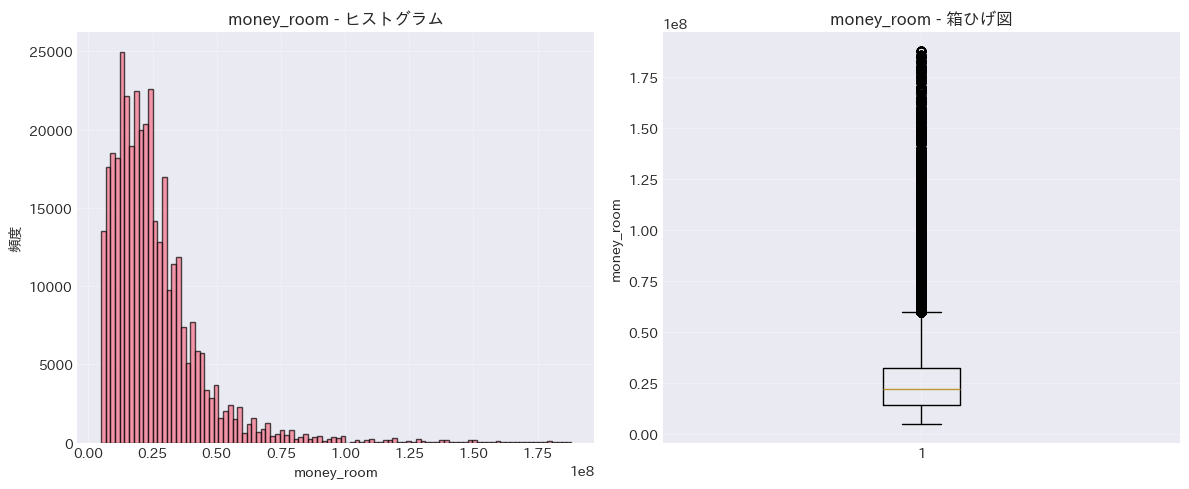

In [12]:
# 例: 目的変数の分布（訓練データのみ）
if "money_room" in train.columns:
    plot_distribution(train, "money_room", bins=100, figsize=(12, 5))

## 6. カテゴリカラムの分布

In [13]:
# カテゴリカラムのサマリー
categorical_summary = get_categorical_summary(train, max_unique=50)

print("[カテゴリカラムのサマリー（ユニーク数50以下）]")
print(categorical_summary.head(20))

[カテゴリカラムのサマリー（ユニーク数50以下）]
shape: (20, 4)
┌──────────────────────────┬──────────────┬────────────────────────────┬──────────┐
│ column                   ┆ unique_count ┆ top_value                  ┆ top_freq │
│ ---                      ┆ ---          ┆ ---                        ┆ ---      │
│ str                      ┆ i64          ┆ str                        ┆ i64      │
╞══════════════════════════╪══════════════╪════════════════════════════╪══════════╡
│ statuses                 ┆ 232339       ┆ None                       ┆ 12590    │
│ unit_tag_id              ┆ 209158       ┆ None                       ┆ 63248    │
│ full_address             ┆ 172933       ┆ 東京都中央区勝どき5丁目3-1 ┆ 69       │
│ snapshot_modify_date     ┆ 170780       ┆ 2020-01-30 22:54:39        ┆ 117      │
│ homes_building_name      ┆ 144790       ┆ None                       ┆ 25994    │
│ building_tag_id          ┆ 127515       ┆ None                       ┆ 28145    │
│ building_name            ┆ 69370        ┆ No

### 主要なカテゴリカラムの分布確認

**TODO**: 実際のデータで重要そうなカラムを選んで可視化

In [14]:
# 例: カテゴリカラムの分布（ユニーク数が適度に少ないカラムを選択）
# categorical_cols_to_plot = categorical_summary.filter(
#     (pl.col("unique_count") >= 5) & (pl.col("unique_count") <= 20)
# ).head(3)["column"].to_list()

# for col in categorical_cols_to_plot:
#     plot_categorical_distribution(train, col, top_n=15)

## 7. 重複行の確認

In [15]:
# 訓練データの重複確認
train_dup_info = get_duplicate_info(train)

print("[訓練データ - 重複行情報]")
print(f"総行数: {train_dup_info['total_rows']:,}")
print(f"ユニーク行数: {train_dup_info['unique_rows']:,}")
print(f"重複行数: {train_dup_info['duplicate_rows']:,}")
print(f"重複割合: {train_dup_info['duplicate_ratio']:.2%}")

[訓練データ - 重複行情報]
総行数: 363,924
ユニーク行数: 363,924
重複行数: 0
重複割合: 0.00%


In [16]:
# テストデータの重複確認
test_dup_info = get_duplicate_info(test)

print("[テストデータ - 重複行情報]")
print(f"総行数: {test_dup_info['total_rows']:,}")
print(f"ユニーク行数: {test_dup_info['unique_rows']:,}")
print(f"重複行数: {test_dup_info['duplicate_rows']:,}")
print(f"重複割合: {test_dup_info['duplicate_ratio']:.2%}")

[テストデータ - 重複行情報]
総行数: 112,437
ユニーク行数: 112,437
重複行数: 0
重複割合: 0.00%


## 8. 訓練データとテストデータの比較

In [17]:
# 共通カラムの抽出
train_cols = set(train.columns)
test_cols = set(test.columns)

common_cols = train_cols & test_cols
train_only = train_cols - test_cols
test_only = test_cols - train_cols

print("[カラム構成の比較]")
print(f"共通カラム数: {len(common_cols)}")
print(f"訓練データのみ: {train_only}")
print(f"テストデータのみ: {test_only}")

[カラム構成の比較]
共通カラム数: 148
訓練データのみ: {'money_room'}
テストデータのみ: {'id'}


## 9. Train/Test データの要素重複分析（ベン図）

カテゴリカル変数において、訓練データとテストデータで値の重複度合いを確認します。
テストデータに訓練データに存在しない値がある場合、未知カテゴリとして扱う必要があります。

In [18]:
from matplotlib_venn import venn2

# カテゴリカル変数（String型とユニーク数が適度なもの）を選択
categorical_cols = []
for col in common_cols:
    if col in train.columns and col in test.columns:
        # String型または数値型でユニーク数が2~1000のもの
        train_unique = train[col].n_unique()
        if 2 <= train_unique <= 1000:
            categorical_cols.append(col)

print(f"分析対象カテゴリカル変数: {len(categorical_cols)}件")

# 各カラムの重複度合いを計算
overlap_stats = []

for col in categorical_cols[:50]:  # 最大50カラムまで
    # 訓練データとテストデータのユニーク値を取得
    train_values = set(train[col].drop_nulls().unique().to_list())
    test_values = set(test[col].drop_nulls().unique().to_list())
    
    # 重複分析
    train_only = train_values - test_values
    test_only = test_values - train_values
    both = train_values & test_values
    
    overlap_stats.append({
        'column': col,
        'train_unique': len(train_values),
        'test_unique': len(test_values),
        'train_only': len(train_only),
        'test_only': len(test_only),
        'both': len(both),
        'overlap_ratio': len(both) / len(train_values) if len(train_values) > 0 else 0
    })

# DataFrameに変換
overlap_df = pl.DataFrame(overlap_stats).sort('test_only', descending=True)

print(f"\n[Train/Test 要素重複分析 - 上位20件（test_only降順）]")
print(overlap_df.head(20))

分析対象カテゴリカル変数: 70件

[Train/Test 要素重複分析 - 上位20件（test_only降順）]
shape: (20, 7)
┌─────────────────────┬──────────────┬─────────────┬────────────┬───────────┬──────┬───────────────┐
│ column              ┆ train_unique ┆ test_unique ┆ train_only ┆ test_only ┆ both ┆ overlap_ratio │
│ ---                 ┆ ---          ┆ ---         ┆ ---        ┆ ---       ┆ ---  ┆ ---           │
│ str                 ┆ i64          ┆ i64         ┆ i64        ┆ i64       ┆ i64  ┆ f64           │
╞═════════════════════╪══════════════╪═════════════╪════════════╪═══════════╪══════╪═══════════════╡
│ money_sonota2       ┆ 945          ┆ 553         ┆ 595        ┆ 203       ┆ 350  ┆ 0.37037       │
│ land_shidou_a       ┆ 605          ┆ 279         ┆ 461        ┆ 135       ┆ 144  ┆ 0.238017      │
│ money_sonota3       ┆ 526          ┆ 271         ┆ 358        ┆ 103       ┆ 168  ┆ 0.319392      │
│ timelimit_date      ┆ 360          ┆ 90          ┆ 360        ┆ 90        ┆ 0    ┆ 0.0           │
│ reform_place_o

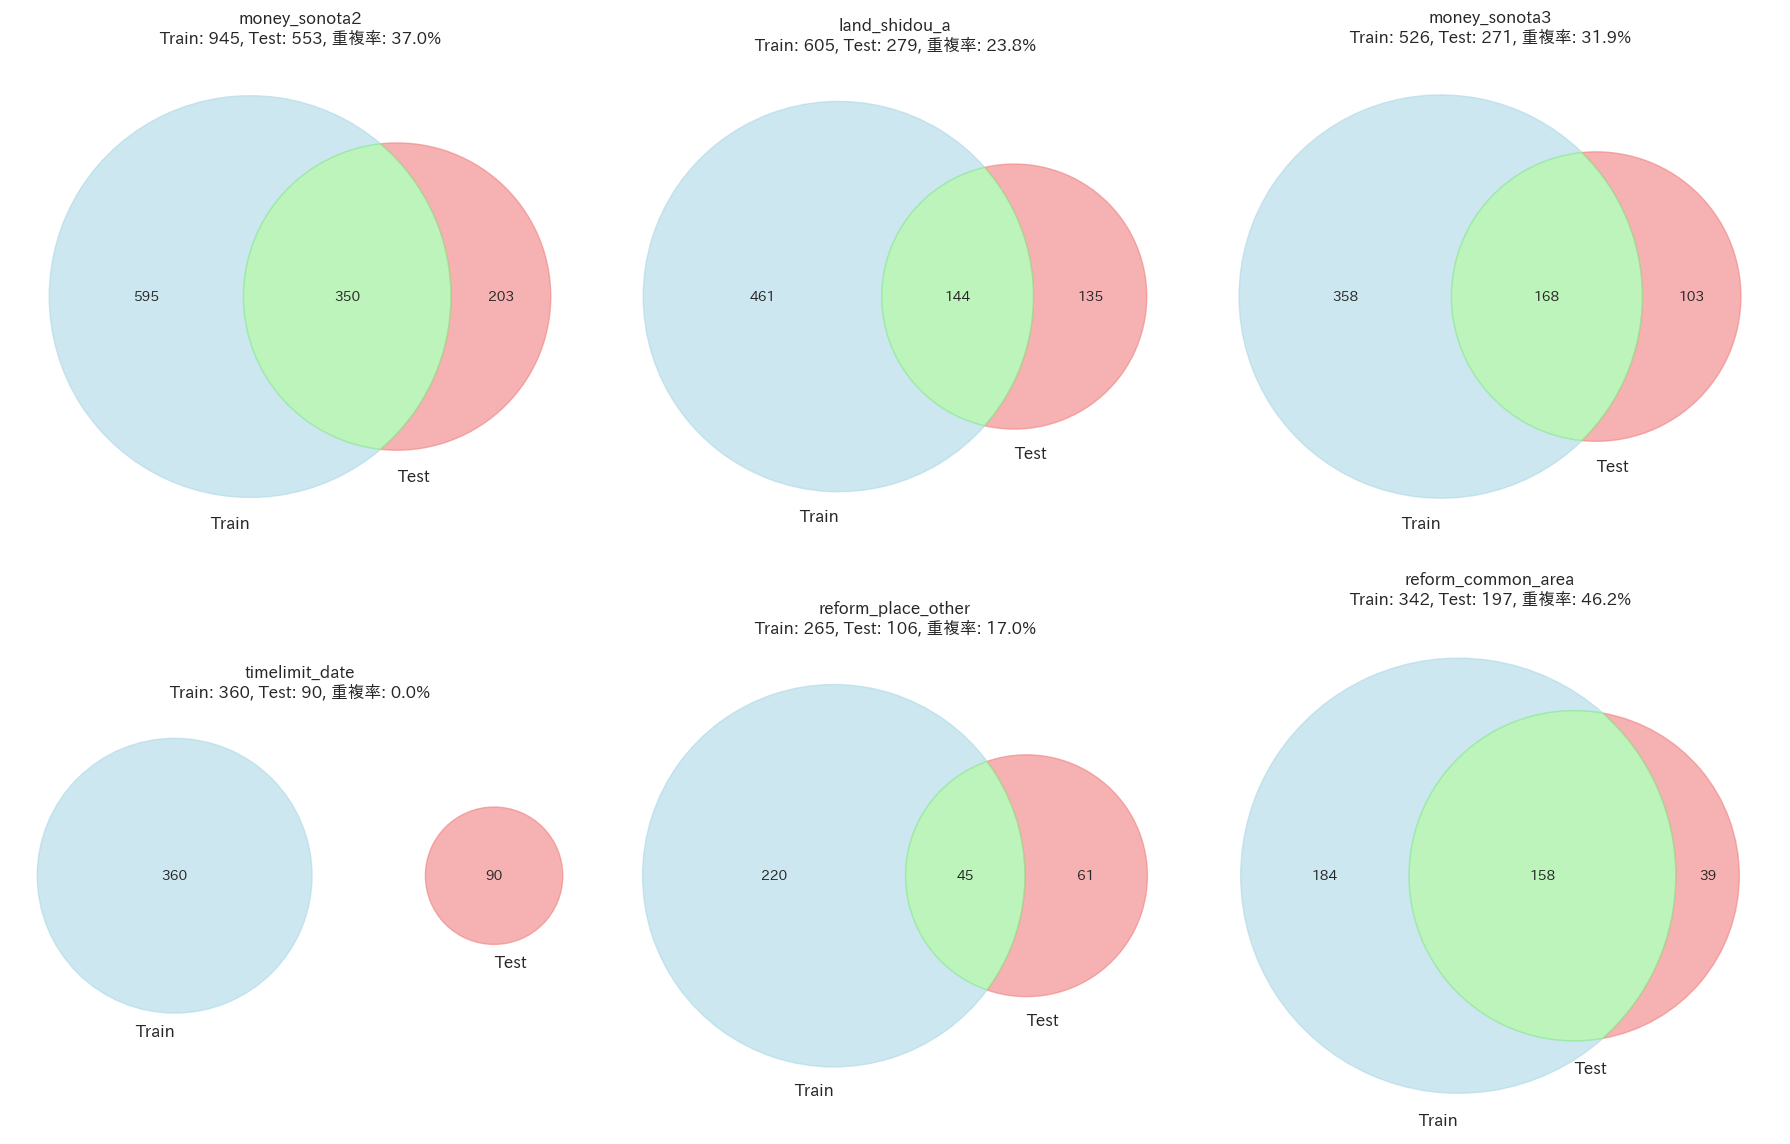


※ 青: Trainのみ, 赤: Testのみ, 緑: 両方に存在


In [19]:
# ベン図で可視化（test_onlyが多い上位6カラム）
top_cols_to_plot = overlap_df.head(6)['column'].to_list()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(top_cols_to_plot):
    row = overlap_df.filter(pl.col('column') == col).row(0, named=True)
    
    # ベン図の作成
    ax = axes[idx]
    venn = venn2(
        subsets=(row['train_only'], row['test_only'], row['both']),
        set_labels=('Train', 'Test'),
        ax=ax
    )
    
    # タイトルと詳細情報
    ax.set_title(
        f"{col}\n"
        f"Train: {row['train_unique']}, Test: {row['test_unique']}, "
        f"重複率: {row['overlap_ratio']:.1%}",
        fontsize=12,
        pad=10
    )
    
    # ベン図の色設定
    if venn.get_patch_by_id('10'):
        venn.get_patch_by_id('10').set_color('lightblue')
        venn.get_patch_by_id('10').set_alpha(0.6)
    if venn.get_patch_by_id('01'):
        venn.get_patch_by_id('01').set_color('lightcoral')
        venn.get_patch_by_id('01').set_alpha(0.6)
    if venn.get_patch_by_id('11'):
        venn.get_patch_by_id('11').set_color('lightgreen')
        venn.get_patch_by_id('11').set_alpha(0.6)

plt.tight_layout()
plt.show()

print(f"\n※ 青: Trainのみ, 赤: Testのみ, 緑: 両方に存在")

## 9. 初期EDAのまとめ

**ここに気づいた点をメモする**

### データの特徴
- 行数: 訓練データ X 件、テストデータ Y 件
- カラム数: Z 件
- 欠損値が多いカラム: [リスト]
- データ型の構成: [メモ]

### 次のステップ
- [ ] ターゲット変数の詳細分析（02_target_analysis.ipynb）
- [ ] 特徴量間の相関分析
- [ ] 時系列パターンの確認（target_ym カラム）
- [ ] 外れ値の検出と対応方針の検討

### 前処理で対応が必要そうな項目
- [ ] 欠損値の補完方針
- [ ] カテゴリ変数のエンコーディング
- [ ] 数値変数のスケーリング
- [ ] 外れ値の処理